In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import pandas as pd
import numpy as np
from guess_language import guess_language
import re
import spell


#Tokenizers
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer

#Lemmatization and stemming
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

#NLTK
import nltk
from nltk.corpus import stopwords

#Lexicon
from nltk.sentiment import vader

from Visualization import Visualization


In [182]:
data = pd.read_csv('rebtel.csv')

In [183]:
#Guess Language to filter non-english written messages
data['Language'] = [guess_language(text) for text in data.Review]

In [184]:
en_data = data.loc[data.Language == 'en']
en_data.reset_index(inplace=True)
del en_data['index']

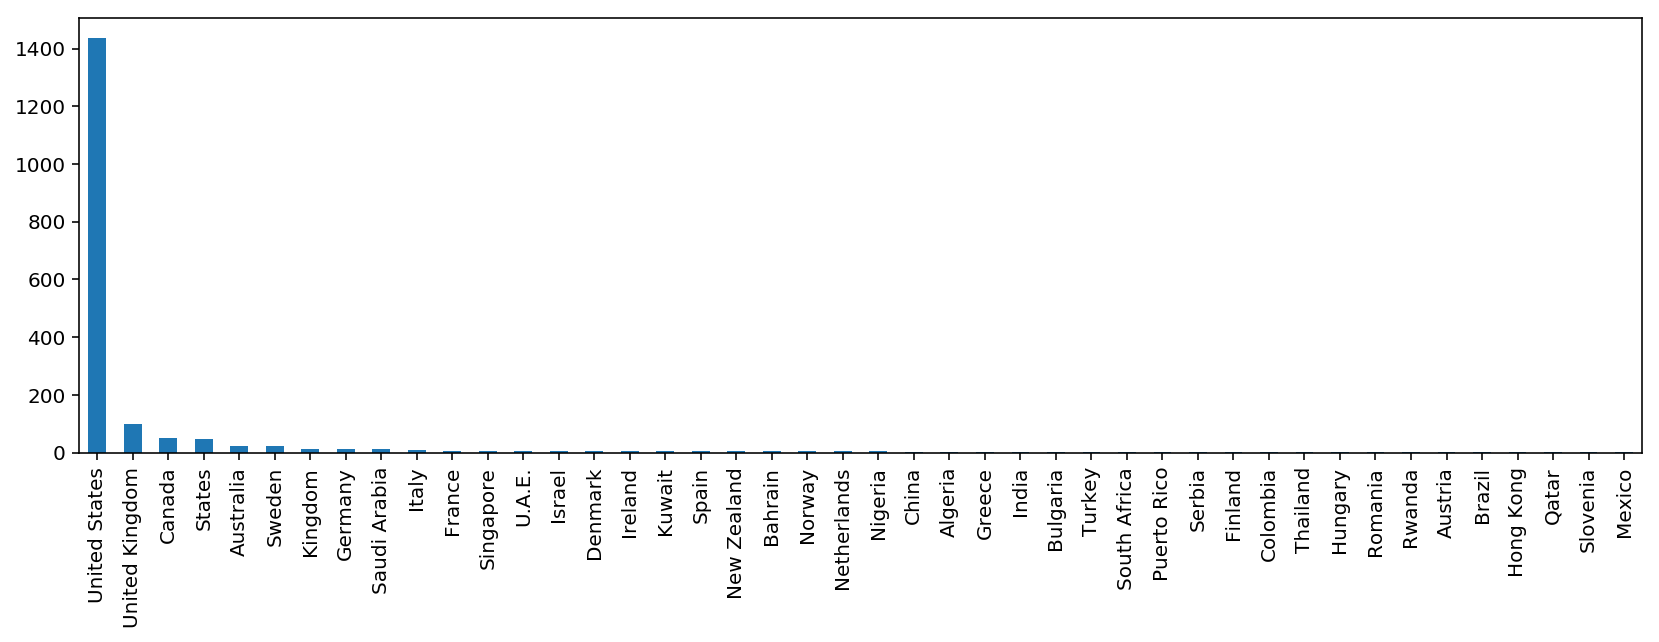

In [185]:
en_data.Country.value_counts().plot(kind='bar',figsize=(14,4))

In [186]:
#Preprocessing num/price and company's name
def tag_nums(text):
    text = put_price(text)
    label_num = re.sub(".\d+.", " NUM ", text )
    label_price = re.sub("\$+.NUM.", " PRICE ", label_num )
    label_company = re.sub("[Rr][Ee][Bb][Tt][Ee][Ll]", " COMPANY ", label_price  )
    
    return label_company

def num_before(tokens,index):
    if index == 0:
        return False#0
    else:
        if tokens[index-1].isdigit():
            return True#1
        else:
            return False#0 

def num_after(tokens,index):
    if index == len(tokens):
        return False#0
    else:
        if index <= len(tokens)-2:
            if tokens[index+1].isdigit():
                return True#1
            else: return False#0
        else:
            return False#0 


In [187]:
#Preprocessing num/price and company's name
def put_price(text):
    
    tokens = tknzr.tokenize(text)
    money_char = {'$','£','€'}
    flag = 0 
    bef_true = False
    edit_text = []
    
    for token in range(len(tokens)):
        
        if tokens[token] in money_char :
            
            bef_true = num_before(tokens,token)
            aft_true = num_after(tokens,token)
            
            if bef_true:
                if token is not 0:
                    edit_text.insert(token-1,"$")
                    bef_true = False
            else:
                edit_text.append("$")
        else:
            edit_text.append(tokens[token])
            
    edit_text = " ".join(edit_text)
    return edit_text

In [188]:
#Preprocessing not information 
def tag_nots(text):
    
    not_words = {'not','never','no','none','nobody','nothing','neither','nowhere','never',
                'dont','wont','cant','hadnt','couldnt',"n't"}
    
    tokens = nltk.word_tokenize(text)

    flag = 0 
    edit_text = []
    for token in tokens:
        if not token.isupper():
            token = token.lower()
            if token in not_words:
                flag = 1
                edit_text.append(token.lower())
            else:
                if flag is 1:
                    token = "!" + token
                    flag = 0
                edit_text.append(token.lower())
        else:
            edit_text.append(token)
        
    edit_text = " ".join(edit_text)
    return edit_text

In [189]:
#Create tokenizer objects
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
tokenizer = RegexpTokenizer(r'\w+')
v = vader.SentimentIntensityAnalyzer()

In [190]:
# Map any nunmber to PRICE/NUM label
pd.options.mode.chained_assignment = None

en_data['Num_inc_title'] =  [tag_nums(review) for review in en_data['Title'] ]
en_data['Num_inc_review'] =  [tag_nums(review) for review in en_data['Review'] ]

In [191]:
def isrelevant(word):
    
    
    neu_relevant = {'big','app','skype','call','calls',
                    'scamming','billed',' messaging',
                    'website','cant','logo','max','go',
                    'get','cheap','i',"it",'is','affordable'}
    
    
    pol =  v.polarity_scores(word)
    
    if pol['neg'] == 1 or pol['pos'] == 1:
        return True
    else:
        if not word.isalpha():
            if word == "n't":
                return False
            else:
                return True
        else:
            if word.lower() in neu_relevant:
                return True
            else:
                
                return False

In [192]:
def spell_checked(data,columnName):
    
    avoid = {"``",",",'"',"`","-",":"}
    
    crtd_messages = []

    for m in data[columnName]:
        
        n_w = []
        for word in nltk.word_tokenize(m):
            if not isrelevant(word):
                tmp_w = spell.correct(word)
            else:
                tmp_w = word
            if tmp_w not in avoid:
                n_w.append(tmp_w)
        n_m = " ".join(n_w) 
        crtd_messages.append(n_m)
    
    return crtd_messages

In [ ]:
# Check spelling of title and reviews
en_data['Num_inc_title'] = spell_checked(en_data,'Num_inc_title')
en_data['Num_inc_title'] = spell_checked(en_data,'Num_inc_title')

In [20]:
#Include lexicon object to rate sentiment of review
v = vader.SentimentIntensityAnalyzer()
visual = Visualization()

In [21]:
#Lexicon scores are evaluated before preprocessing NOT
t_scores = [v.polarity_scores(review) for review in en_data["Num_inc_title"]]
scores = [v.polarity_scores(review) for review in en_data["Num_inc_review"]]

en_data['r_compound'] = [score.get('compound') for score in scores]
en_data['r_negative'] = [-score.get('neg') for score in scores]
en_data['r_positive'] = [score.get('pos') for score in scores]
en_data['r_neutral'] = [score.get('neu') for score in scores]

en_data['t_compound'] = [score.get('compound') for score in t_scores]
en_data['t_negative'] = [-score.get('neg') for score in t_scores]
en_data['t_positive'] = [score.get('pos') for score in t_scores]
en_data['t_neutral'] = [score.get('neu') for score in t_scores]


In [22]:
# Map any "not" condition to !+word(eg: not true = !true)
en_data["NN_inc_title"] = [tag_nots(review) for review in en_data['Num_inc_title']]
en_data["NN_inc_review"] = [tag_nots(review) for review in en_data['Num_inc_review']]

#If another preprocessing should be included it needs
# to be added here

In [23]:
def remove_stops(data,columnName):
    
    reviews = []
    
    stops = set(stopwords.words("english"))


    not_words = {'not','never','no','nor','none','nobody','nothing','neither','nowhere','never',
                'dont','wont','cant','hadnt','couldnt',"n't",'musn','don','hadn','couldn'}

    stops = set([word for word in stops if word not in not_words])

    for review in data[columnName]:
        review = tknzr.tokenize(review)
        text_prosc = [word for word in review if not word.lower() in stops]
        cleaned_text = " ".join(text_prosc)
        reviews.append(cleaned_text)
    return reviews

In [25]:
def correct_puncts(text):
    label_punct = re.sub("\!\s", "!", text )
    label_punct = re.sub("[\`+]", "", label_punct)
    label_punct = re.sub("[\.]", "", label_punct)
    label_punct = re.sub("[\?+]", "", label_punct)
    return label_punct

def correct_punctuations(data,columnName):
    
    reviews = []

    for review in data[columnName]:
        review = correct_puncts(review)
        reviews.append(review)
    return reviews
    

In [26]:
# Remove stopwords and keep only relevant words

en_data["Rel_w_title"] = remove_stops(en_data,"NN_inc_title")
en_data["Rel_w_review"] = remove_stops(en_data,"NN_inc_review")

#Correct split of ! punctuation

en_data["Rel_w_title"] = correct_punctuations(en_data,"Rel_w_title")
en_data["Rel_w_review"] = correct_punctuations(en_data,"Rel_w_review")

In [27]:
#Remove irrelevant columns
en_data.drop(["Review","Title","raw time","Username",
            "Genre","Language"], axis=1, inplace=True)

In [28]:
# Lemmatization
wordnet = WordNetLemmatizer() 

def lemmatization(data,columnName):
    lemmas = []
    for message in data[columnName]:
        tkn = nltk.word_tokenize(message)
        wordnet_lemmas = [wordnet.lemmatize(token) for token in tkn] 
        lemmas.append(" ".join(wordnet_lemmas))
    return lemmas

In [29]:
en_data["Lems_title"] = lemmatization(en_data,"Rel_w_title")
en_data["Lems_review"] = lemmatization(en_data,"Rel_w_review")

In [30]:
#Stemming
def stemming(data,columnName,stem): 
    lemmas = []
    
    snowball = SnowballStemmer("english")
    porter = PorterStemmer()
    lancaster = LancasterStemmer()
    
    for message in data[columnName]:
        tkn = nltk.word_tokenize(message)
        if stem is "snow":
            stemmed = [snowball.stem(token) for token in tkn]
        elif stem is "porter":
            stemmed = [porter.stem(token) for token in tkn]
        elif stem is "lanc":
            stemmed = [lancaster.stem(token) for token in tkn]
        lemmas.append(" ".join(stemmed))
    return lemmas

In [31]:
en_data["Snow_title"] = stemming(en_data,"Rel_w_title","snow")  
en_data["Snow_review"] = stemming(en_data,"Rel_w_review","snow")

en_data["Porter_title"] = stemming(en_data,"Rel_w_title","porter")  
en_data["Porter_review"] = stemming(en_data,"Rel_w_review","porter")

en_data["Lanc_title"] = stemming(en_data,"Rel_w_title","lanc")  
en_data["Lanc_review"] = stemming(en_data,"Rel_w_review","lanc")


In [32]:
# Join text from title and review
def mg_title_rev(data,approach):
    # Join text from title and review
    merged_text = []
    for i in range(len(data)):
        mrgd = data[approach + "_title"][i] + " " + data[approach + "_review"][i]
        merged_text.append(mrgd)
    return merged_text

In [33]:
en_data['Lems_title_review'] = mg_title_rev(en_data,"Lems")
en_data['Snow_title_review'] = mg_title_rev(en_data,"Snow")
en_data['Porter_title_review'] = mg_title_rev(en_data,"Porter")
en_data['Lanc_title_review'] = mg_title_rev(en_data,"Lanc")
en_data['Rel_w_title_review'] = mg_title_rev(en_data,'Rel_w')

In [34]:
#Map Country to a numeric value
def map_country(ctyName,countries):
    
    if ctyName in countries:
        value = countries[ctyName]
    else:
        value = countries['Unkown']

    return value

ctyNames = en_data.Country.unique() 
ctyNames = np.append(ctyNames,['Unkown'])
countries = {ctyNames[i]: i for i in range(0, len(ctyNames))}
en_data['Key_country'] = [map_country(cty,countries) for cty in en_data.Country]

In [47]:
def data_perclass(dataset,classes):
    datasets = []
    
    for class_ in classes:
        
        tmp_data = dataset.loc[dataset.Rating == class_]
        datasets.append(tmp_data)
    return datasets

def get_mean_std(dataset,column):
    
    mean = dataset[column].mean()
    std = dataset[column].std()
    
    return (mean,std)

In [48]:
def mean_std_class(datasets):
    
    r_metrics = []
    t_metrics = []
    
    for dataset in datasets:
        
        r_comp = get_mean_std(dataset,"r_compound")
        r_neg = get_mean_std(dataset,"r_negative")
        r_pos = get_mean_std(dataset,"r_positive")
        r_neu = get_mean_std(dataset,"r_neutral")
        
        t_comp = get_mean_std(dataset,"t_compound")
        t_neg = get_mean_std(dataset,"t_negative")
        t_pos = get_mean_std(dataset,"t_positive")
        t_neu = get_mean_std(dataset,"t_neutral")
        
        
        r_metric = [r_comp,r_neg,r_pos,r_neu]
        t_metric = [t_comp,t_neg,t_pos,t_neu]
        
        r_metrics.append(r_metric)
        t_metrics.append(t_metric)
        
    return r_metrics,t_metrics

In [61]:
def get_thres(metrics,n_value):
    
    mean = metrics[0]
    std = metrics[1] / n_value
    
    min_ = mean - std
    max_ = mean + std
    
    return min_,max_
    

In [132]:
def get_threshold(class_metrics,n_split):
    
    threshold = []
    n_split= n_split


    for class_metric in class_metrics:
    
        min_comp, max_comp = get_thres(class_metric[0], n_split)
        min_neg, max_neg = get_thres(class_metric[1], n_split)
        min_pos, max_pos = get_thres(class_metric[2], n_split)
        min_neu, max_neu = get_thres(class_metric[3], n_split)
    
        thres = [(min_comp, max_comp),(min_neg, max_neg),
                 (min_pos, max_pos),(min_neu, max_neu)]
    
        threshold.append(thres)
    return threshold 

In [133]:
#Generate predictor based on Lexicon metrics
classes = [1,2,3,4,5]
datasets = data_perclass(en_data,classes)
r_metrics,t_metrics = mean_std_class(datasets)

In [135]:
def get_class(element, class_thres, metricName):
    
    decision = {'1':0,'2':0,'3':0,'4':0,'5':0}
    
    if metricName.endswith('compound'):
        i = 0
    elif metricName.endswith('negative'):
        i = 1
    elif metricName.endswith('positive'):
        i = 2
    elif metricName.endswith('neutral'):
        i = 3
     
    cl_1 = class_thres[0][i]
    cl_2 = class_thres[1][i]
    cl_3 = class_thres[2][i]
    cl_4 = class_thres[3][i]
    cl_5 = class_thres[4][i]
    
    if element > cl_1[0] and element < cl_1[1]:
        decision['1'] +=1
    
    if element > cl_2[0] and element < cl_2[1]:
        decision['2'] +=1
    
    if element > cl_3[0] and element < cl_3[1]:
        decision['3'] +=1
    
    if element > cl_4[0] and element < cl_4[1]:
        decision['4'] +=1
    if element > cl_5[0] and element < cl_5[1]:
        decision['5'] +=1
    
    return decision

    

In [136]:
def predict_class(data,r_thres,t_thres):
    
    predictions = []
    
    for i in range(len(data)):
        
        decision = {'1':0,'2':0,'3':0,'4':0,'5':0}
        
        r_comp = get_class(data['r_compound'][i], r_thres,"r_compound")
        r_neg = get_class(data['r_negative'][i], r_thres,"r_negative")
        r_pos = get_class(data['r_positive'][i], r_thres,"r_positive")
        r_neu = get_class(data['r_neutral'][i], r_thres,"r_neutral")
        
        t_comp = get_class(data['t_compound'][i], t_thres,"t_compound")
        t_neg = get_class(data['t_negative'][i], t_thres,"t_negative")
        t_pos = get_class(data['t_positive'][i], t_thres,"t_positive")
        t_neu = get_class(data['t_neutral'][i], t_thres,"t_neutral")
        
        results = [r_comp,r_neg,r_pos,r_neu,t_comp,t_neg,t_pos,t_neu]
        
        for result in results:
            for k,v in result.items():
                if k in decision:
                    decision[k] += v
                    
        prediction = max(decision, key=decision.get)
        predictions.append(prediction)
        
    return predictions

In [137]:
def compare_values(data):
    
    y_test =  [str(i) for i in data['Rating'].get_values()]
    test_preds = [str(i) for i in data['Lex_preds'].get_values()]
    
    return y_test,test_preds

In [178]:
#Create thresholds to determine each class
r_thres = get_threshold(r_metrics,2)
t_thres = get_threshold(t_metrics,2)

In [179]:
en_data["Lex_preds"] = predict_class(en_data,r_thres,t_thres)

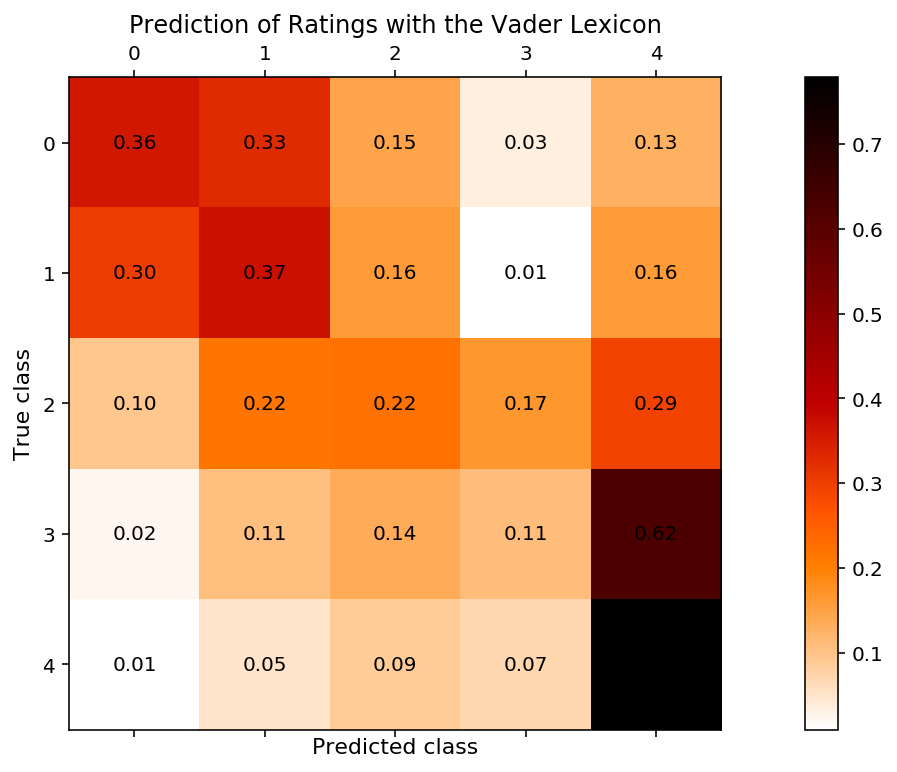

In [180]:
y_test, test_preds = compare_values(en_data)
visual.plot_confusion_matrix(y_test,test_preds, 'Prediction of Ratings with the Vader Lexicon')

In [181]:
##Save data into a local file
en_data.to_csv('rebtel_w_lexicon.csv',index=False)